# Chapter 10 - Portfolio theory introduction
---

In [1]:
# Preamble
import pandas as pd
import numpy as np
import os 
import re
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.ticker as mticker
import seaborn as sns
import yfinance as yf  # This gets us prices from Yahoo finance. See https://pypi.org/project/yfinance/
from linearmodels.panel import PanelOLS
import math
import statsmodels.api as sm
import statsmodels.formula.api as smf
from tabulate import tabulate
from IPython.display import display, Math

if os.name=='nt':
    import xlwings as xw


def get_nzx(url):
    df = pd.read_html(url)[0]
    df.columns = df.columns.str.lower()
    lyst = ['price', 'volume', 'value', 'capitalisation', 'market capitalisation', 'percentage change', 'trade count']
    df[lyst] = df[lyst].replace({'\$': '', ',': ''}, regex=True).apply(pd.to_numeric,  errors='coerce')
    df['green bond']= df['green bond'].map({'false': 0, 'true': 1})
    df = df[~df['company'].str.contains('Smartshares')]
    df['code'] = df['code']+".NZ"
    nzx = df['code'].to_list()
    return(df[df['market capitalisation']>0], nzx)


def set_xmargin(ax, left=0.0, right=0.3):
    ax.set_xmargin(0)
    ax.autoscale_view()
    lim = ax.get_xlim()
    delta = np.diff(lim)
    left =  lim[0] - delta*left
    right = lim[1] + delta*right
    ax.set_xlim(left,right)


def nice_print(df, k=1, name=""):
    if isinstance(df, pd.DataFrame):
        print(tabulate(k*df, tablefmt="fancy_grid", floatfmt=".4f", headers="keys"))
    elif isinstance(df, pd.Series):
        df.name= name
        df=df.to_frame()
        print(tabulate(k*df, tablefmt="fancy_grid", floatfmt=".4f", headers="keys"))

---

**Get NZX tickers from its web-site**


In [2]:
dfm, nzx  = get_nzx('https://www.nzx.com/markets/NZSX')
nzx+=['^NZ50']
print(dfm.head(3))
print(nzx)

     code                                           company  price  \
0  AFI.NZ  Australian Foundation Investment Company Limited   8.84   
1  ANZ.NZ   Australia and New Zealand Banking Group Limited  28.03   
3  MHJ.NZ                Michael Hill International Limited   1.16   

             change  volume      value  capitalisation  percentage change  \
0    $0.090 / 1.03%    4003   35184.37     10872371745           1.028571   
1    $0.300 / 1.08%   19779  553333.48     78318739997           1.081861   
3  -$0.020 / -1.69%    1615    1889.68       450411034          -1.694915   

       type  green bond  trade count currency code  market capitalisation  
0  CLOSEEND         NaN           17           NZD           1.119854e+08  
1       NaN         NaN          151           NZD           6.970368e+08  
3       NaN         NaN           22           NZD           9.643300e+07  
['AFI.NZ', 'ANZ.NZ', 'DOW.NZ', 'MHJ.NZ', 'WBC.NZ', 'ALD.NZ', 'AKL.NZ', 'DGC.NZ', 'VSL.NZ', 'VNT.NZ', 'CRP.

**Obtain returns:**

In [3]:
def returns(nzx, start, end):
    df_close = yf.download(nzx, start, end, progress=True, interval="1mo")['Adj Close']
    df_close.dropna(how = 'all', inplace=True, axis = 1)
    df_close.sort_index(inplace=True)
    df_close.index = pd.to_datetime(df_close.index, format ='%Y-%m-%d')
    df_close.columns = [re.sub(r'.NZ$|\^', "", x) for x in list(df_close)]
    return list(df_close), df_close.resample('M').last()

nzx_set, df_close = returns(nzx, '2011-10-01', '2022-04-30')

[*********************100%***********************]  153 of 153 completed

10 Failed downloads:
- BIF.NZ: No data found for this date range, symbol may be delisted
- BRMWG.NZ: No data found, symbol may be delisted
- ALD.NZ: Data doesn't exist for startDate = 1317380400, endDate = 1651233600
- NTLOB.NZ: No data found, symbol may be delisted
- BIT.NZ: No data found for this date range, symbol may be delisted
- KFLWG.NZ: No data found, symbol may be delisted
- AKL.NZ: No data found, symbol may be delisted
- CO2.NZ: No data found for this date range, symbol may be delisted
- PLP.NZ: No data found for this date range, symbol may be delisted
- FCT.NZ: No data found for this date range, symbol may be delisted


array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

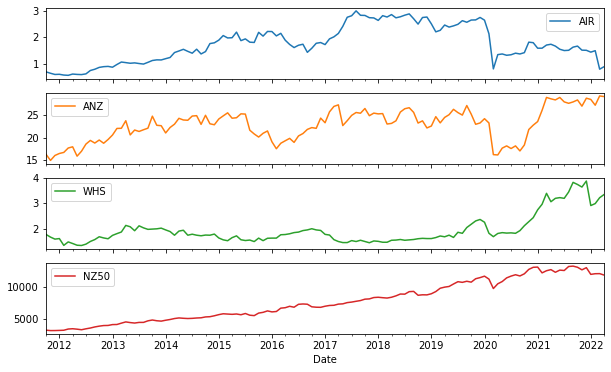

In [4]:
stocks_list = ["AIR", "ANZ", 'WHS', 'NZ50'] #, 'BGP', 'FPH', 'RYM', 'AIA', 'THL', 'NZ50']  
data = df_close[stocks_list]
data.plot(figsize=(10, 6), subplots=True)

In [5]:
data

,AIR,ANZ,WHS,NZ50
Date,,,,
2011-10-31,0.686770,16.285666,1.765797,3332.560059
2011-11-30,0.634445,14.946797,1.661627,3270.209961
2011-12-31,0.588660,16.045309,1.582930,3274.709961
2012-01-31,0.595200,16.484089,1.604036,3296.199951
2012-02-29,0.565768,16.721270,1.334938,3322.530029
...,...,...,...,...
2021-12-31,1.510000,28.765333,3.880952,13033.769531
2022-01-31,1.440000,28.492123,2.910714,11995.370117
2022-02-28,1.495000,27.204121,2.988333,12096.679688


---

### Stocks Statistics 

**Calculate monthly returns using the difference of logs**

In [6]:
monthly_ret = np.log(data).diff().dropna()
monthly_ret.tail(5)

,AIR,ANZ,WHS,NZ50
Date,,,,
2021-12-31,-0.003306,0.063304,0.063393,0.025978
2022-01-31,-0.047466,-0.009543,-0.287682,-0.083023
2022-02-28,0.037483,-0.046259,0.026317,0.008410
2022-03-31,-0.637449,0.072954,0.075035,0.001122
2022-04-30,0.113155,-0.004679,0.038409,-0.018835


**Geometric mean**

$$\begin{aligned} \bar{R}_{G i} &=\sqrt[T]{\left(1+R_{i 1}\right) \times\left(1+R_{i 2}\right) \times \ldots \times\left(1+R_{i, T-1}\right) \times\left(1+R_{i T}\right)}-1 \\ &=\sqrt[T]{\prod_{t=1}^{T}\left(1+R_{i t}\right)-1} \end{aligned}$$

╒═════════════════════╤══════════╤═════════╤══════════╤═════════╕
│ Date                │      AIR │     ANZ │      WHS │    NZ50 │
╞═════════════════════╪══════════╪═════════╪══════════╪═════════╡
│ 2021-12-31 00:00:00 │  -0.3306 │  6.3304 │   6.3393 │  2.5978 │
├─────────────────────┼──────────┼─────────┼──────────┼─────────┤
│ 2022-01-31 00:00:00 │  -4.7466 │ -0.9543 │ -28.7682 │ -8.3023 │
├─────────────────────┼──────────┼─────────┼──────────┼─────────┤
│ 2022-02-28 00:00:00 │   3.7483 │ -4.6259 │   2.6317 │  0.8410 │
├─────────────────────┼──────────┼─────────┼──────────┼─────────┤
│ 2022-03-31 00:00:00 │ -63.7449 │  7.2954 │   7.5035 │  0.1122 │
├─────────────────────┼──────────┼─────────┼──────────┼─────────┤
│ 2022-04-30 00:00:00 │  11.3155 │ -0.4679 │   3.8409 │ -1.8835 │
╘═════════════════════╧══════════╧═════════╧══════════╧═════════╛


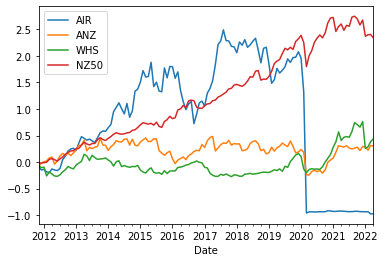

In [7]:
monthly_ret.add(1).cumprod().sub(1).plot() # monthly_ret.cumsum().apply(np.exp).plot()
nice_print(monthly_ret.tail(5), k=100, name="")

In [8]:
def prelim_tables(df):
    df = df.copy()
    df['year'] = df.index.year.astype(int)
    df.set_index('year', append=True, inplace=True)
    print('Returns by year')
    nice_print(df.add(1).groupby('year').prod().sub(1), 100)
    
prelim_tables(monthly_ret) 

Returns by year
╒════════╤══════════╤══════════╤══════════╤═════════╕
│   year │      AIR │      ANZ │      WHS │    NZ50 │
╞════════╪══════════╪══════════╪══════════╪═════════╡
│   2011 │ -14.8215 │  -2.0953 │ -10.6374 │ -1.7537 │
├────────┼──────────┼──────────┼──────────┼─────────┤
│   2012 │  47.9853 │  19.6986 │  -2.4437 │ 23.5295 │
├────────┼──────────┼──────────┼──────────┼─────────┤
│   2013 │  25.3922 │  12.3515 │  23.6134 │ 15.8919 │
├────────┼──────────┼──────────┼──────────┼─────────┤
│   2014 │  50.0837 │  -0.7758 │ -13.0266 │ 17.3026 │
├────────┼──────────┼──────────┼──────────┼─────────┤
│   2015 │  18.0179 │  -7.8447 │ -11.3530 │ 12.9256 │
├────────┼──────────┼──────────┼──────────┼─────────┤
│   2016 │ -23.2821 │  10.6087 │  18.6205 │  7.9612 │
├────────┼──────────┼──────────┼──────────┼─────────┤
│   2017 │  47.5981 │   1.2943 │ -22.9155 │ 21.7938 │
├────────┼──────────┼──────────┼──────────┼─────────┤
│   2018 │  -0.2405 │ -14.4121 │   6.0473 │  4.4771 │
├────────┼──

In [9]:
# Mean Returns
mean_ret = monthly_ret.mean()
mean_ret.name = 'Mean Monthly Return'
print(mean_ret*100)

AIR     0.201261
ANZ     0.461396
WHS     0.507586
NZ50    1.009109
Name: Mean Monthly Return, dtype: float64


In [10]:
# Sigma
sigma    = monthly_ret.std()
sigma.name = 'Sigma'
print(sigma)

AIR     0.137428
ANZ     0.067942
WHS     0.064662
NZ50    0.030847
Name: Sigma, dtype: float64


AIR     0.002013
ANZ     0.004614
WHS     0.005076
NZ50    0.010091
Name: Mean Monthly Return, dtype: float64


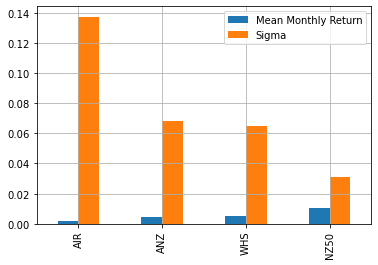

In [11]:
mean_ret.to_frame().join(sigma.to_frame()).sort_values(by=['Mean Monthly Return']).plot(kind='bar', grid=True)
print(mean_ret)

#### COMPUTING COVARIANCE AND CORRELATION ####

In [12]:
# Calculate excess returns
print('Monthly returns')
nice_print(monthly_ret.tail(5))
print('Mean returns')
nice_print(mean_ret)

excess_ret = (monthly_ret - mean_ret)

print('Excess returns')
nice_print(excess_ret.head(2))

print('Excess returns using .sub()')
excess_ret = monthly_ret.sub(mean_ret)
nice_print(excess_ret.head(2))

Monthly returns
╒═════════════════════╤═════════╤═════════╤═════════╤═════════╕
│ Date                │     AIR │     ANZ │     WHS │    NZ50 │
╞═════════════════════╪═════════╪═════════╪═════════╪═════════╡
│ 2021-12-31 00:00:00 │ -0.0033 │  0.0633 │  0.0634 │  0.0260 │
├─────────────────────┼─────────┼─────────┼─────────┼─────────┤
│ 2022-01-31 00:00:00 │ -0.0475 │ -0.0095 │ -0.2877 │ -0.0830 │
├─────────────────────┼─────────┼─────────┼─────────┼─────────┤
│ 2022-02-28 00:00:00 │  0.0375 │ -0.0463 │  0.0263 │  0.0084 │
├─────────────────────┼─────────┼─────────┼─────────┼─────────┤
│ 2022-03-31 00:00:00 │ -0.6374 │  0.0730 │  0.0750 │  0.0011 │
├─────────────────────┼─────────┼─────────┼─────────┼─────────┤
│ 2022-04-30 00:00:00 │  0.1132 │ -0.0047 │  0.0384 │ -0.0188 │
╘═════════════════════╧═════════╧═════════╧═════════╧═════════╛
Mean returns
╒══════╤════════╕
│      │        │
╞══════╪════════╡
│ AIR  │ 0.0020 │
├──────┼────────┤
│ ANZ  │ 0.0046 │
├──────┼────────┤
│ WHS  │ 0.00

**Using Excel to check**

In [13]:
if os.name=='nt':
    wb = xw.Book()  
    sheet = wb.sheets['Sheet1']
    sheet.range('A1').value = monthly_ret
    sheet.range('G1').value = excess_ret

**Covariance**

$$
\frac{1}{N} \sum_{t=1}^{N}\left(r_{i t}-\bar{r}_{i}\right)\left(r_{j t}-\bar{r}_{j}\right)
$$


In [14]:
# Covariance 
(excess_ret['AIR']*excess_ret['ANZ']).mean()

0.0032776412913834824

$$
\frac{1}{N-1} \sum_{t=1}^{N}\left(r_{i t}-\bar{r}_{i}\right)\left(r_{j t}-\bar{r}_{j}\right)
$$

In [15]:
N = len(excess_ret)
(excess_ret['AIR']*excess_ret['ANZ']).mean()*N/(N-1)

0.0033038624217145503

In [16]:
cov_mat  = monthly_ret.cov()
display(Math(r'\rho_{ij}\sigma_i\sigma_j'))
nice_print(cov_mat, 1, 'Covariances')

<IPython.core.display.Math object>

╒══════╤════════╤════════╤════════╤════════╕
│      │    AIR │    ANZ │    WHS │   NZ50 │
╞══════╪════════╪════════╪════════╪════════╡
│ AIR  │ 0.0189 │ 0.0033 │ 0.0016 │ 0.0022 │
├──────┼────────┼────────┼────────┼────────┤
│ ANZ  │ 0.0033 │ 0.0046 │ 0.0009 │ 0.0010 │
├──────┼────────┼────────┼────────┼────────┤
│ WHS  │ 0.0016 │ 0.0009 │ 0.0042 │ 0.0007 │
├──────┼────────┼────────┼────────┼────────┤
│ NZ50 │ 0.0022 │ 0.0010 │ 0.0007 │ 0.0010 │
╘══════╧════════╧════════╧════════╧════════╛


<IPython.core.display.Math object>

╒══════╤════════╤════════╤════════╤════════╕
│      │    AIR │    ANZ │    WHS │   NZ50 │
╞══════╪════════╪════════╪════════╪════════╡
│ AIR  │ 1.0000 │ 0.3538 │ 0.1831 │ 0.5073 │
├──────┼────────┼────────┼────────┼────────┤
│ ANZ  │ 0.3538 │ 1.0000 │ 0.2104 │ 0.4788 │
├──────┼────────┼────────┼────────┼────────┤
│ WHS  │ 0.1831 │ 0.2104 │ 1.0000 │ 0.3719 │
├──────┼────────┼────────┼────────┼────────┤
│ NZ50 │ 0.5073 │ 0.4788 │ 0.3719 │ 1.0000 │
╘══════╧════════╧════════╧════════╧════════╛


<AxesSubplot:>

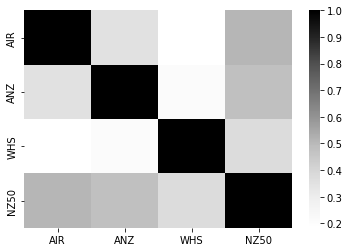

In [17]:
# Correlation Matrix
display(Math(r'\rho_{ij}'))
corr_mat = monthly_ret.corr()
nice_print(corr_mat, 1)
sns.heatmap(corr_mat, cmap="Greys")

In [18]:
# Regression
results = smf.ols('AIR ~ 1 + ANZ', data=monthly_ret).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    AIR   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     17.75
Date:                Tue, 24 May 2022   Prob (F-statistic):           4.81e-05
Time:                        16:09:25   Log-Likelihood:                 80.209
No. Observations:                 126   AIC:                            -156.4
Df Residuals:                     124   BIC:                            -150.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0013      0.012     -0.112      0.9

In [19]:
#Scatter Plot

def scattplot(X, Y, monthly_ret):
    results = smf.ols(Y + ' ~ 1 + ' + X, data=monthly_ret).fit()
    
    fig = plt.figure(figsize=(7,6))
    ax = sns.regplot(x=X, y=Y, data=monthly_ret, scatter_kws={'s':5})
    
    set_xmargin(ax, left=0, right=0)
    
    # Titles and axes names
    ax.set_title(r'Monthly Returns')
    ax.set_xlabel(X)
    ax.set_ylabel(Y)
    plt.grid(linestyle="dotted", color='grey')
    
    # Equation
    plusmin = '-' if results.params.Intercept<0 else '+'
    equation = f'${{{Y}}}$ =  {results.params[1]:.3f} ${{{X}}}$ {plusmin} {abs(results.params.Intercept):.3f}'
    ax.text(y = monthly_ret[Y].max(), x = monthly_ret[X].min(), s = equation)
    plt.show()
    print(results.summary())
    return

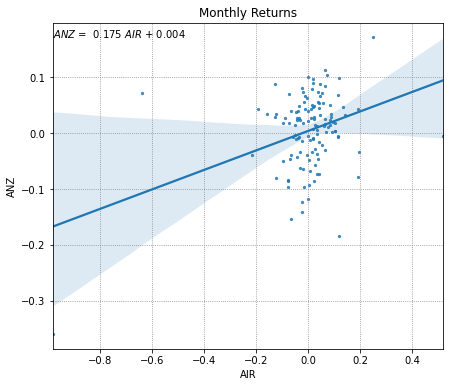

                            OLS Regression Results                            
Dep. Variable:                    ANZ   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     17.75
Date:                Tue, 24 May 2022   Prob (F-statistic):           4.81e-05
Time:                        16:09:26   Log-Likelihood:                 168.97
No. Observations:                 126   AIC:                            -333.9
Df Residuals:                     124   BIC:                            -328.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0043      0.006      0.750      0.4

In [20]:
scattplot('AIR','ANZ', monthly_ret)

**Return on an equally-weigthed portfolio plotted agains the NZ50**

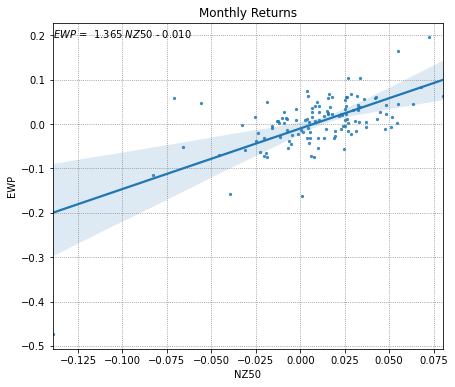

                            OLS Regression Results                            
Dep. Variable:                    EWP   R-squared:                       0.405
Model:                            OLS   Adj. R-squared:                  0.400
Method:                 Least Squares   F-statistic:                     84.37
Date:                Tue, 24 May 2022   Prob (F-statistic):           1.17e-15
Time:                        16:09:27   Log-Likelihood:                 196.59
No. Observations:                 126   AIC:                            -389.2
Df Residuals:                     124   BIC:                            -383.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0099      0.005     -2.054      0.0

In [21]:
# Return on an equally weigthed portfolio
scattplot('NZ50','EWP', monthly_ret.assign(EWP = monthly_ret[[x for x in list(monthly_ret) if x!="NZ50"]].mean(axis=1)))

### Building a portfolio of two stocks
---

[*********************100%***********************]  3 of 3 completed


array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

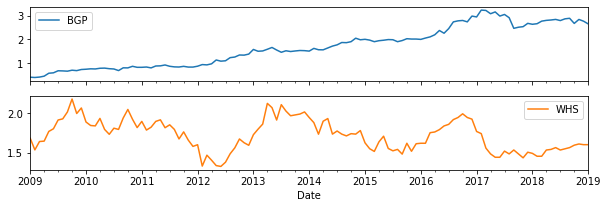

In [22]:
nzx_set, df_close = returns(['BGP.NZ','WHS.NZ']+['^NZ50'], '2009-01-01', '2019-01-01')

stocks_list = ['BGP', 'WHS' ]  
data = df_close[stocks_list]
data.plot(figsize=(10, 3), subplots=True)

In [23]:
monthly_ret = np.log(data).diff().dropna()
mean_ret = monthly_ret.mean()
mean_ret.name = 'Mean Monthly Return'
sigma    = monthly_ret.std()
sigma.name = 'Sigma'

In [24]:
cov_mat

,AIR,ANZ,WHS,NZ50
AIR,0.018886,0.003304,0.001627,0.002151
ANZ,0.003304,0.004616,0.000925,0.001003
WHS,0.001627,0.000925,0.004181,0.000742
NZ50,0.002151,0.001003,0.000742,0.000952


In [25]:
nice_print(mean_ret.to_frame().join(sigma), 1, 'Returns')
cov_mat  = monthly_ret.cov()

print('\nCorrelations')
display(Math(r'\rho_{ij}'))
corr_mat = monthly_ret.corr()
nice_print(corr_mat, 1)

print('\nCovariances:')
display(Math(r'\rho_{ij}\sigma_i\sigma_j'))
nice_print(cov_mat, 1)

╒═════╤═══════════════════════╤═════════╕
│     │   Mean Monthly Return │   Sigma │
╞═════╪═══════════════════════╪═════════╡
│ BGP │                0.0156 │  0.0546 │
├─────┼───────────────────────┼─────────┤
│ WHS │               -0.0004 │  0.0526 │
╘═════╧═══════════════════════╧═════════╛

Correlations


<IPython.core.display.Math object>

╒═════╤════════╤════════╕
│     │    BGP │    WHS │
╞═════╪════════╪════════╡
│ BGP │ 1.0000 │ 0.1844 │
├─────┼────────┼────────┤
│ WHS │ 0.1844 │ 1.0000 │
╘═════╧════════╧════════╛

Covariances:


<IPython.core.display.Math object>

╒═════╤════════╤════════╕
│     │    BGP │    WHS │
╞═════╪════════╪════════╡
│ BGP │ 0.0030 │ 0.0005 │
├─────┼────────┼────────┤
│ WHS │ 0.0005 │ 0.0028 │
╘═════╧════════╧════════╛


In [26]:
# Set proportions
Xa = 0.5
Xb = 1 - Xa
prop = pd.DataFrame(data = [Xa, Xb], columns = ['Weights'],  index=['BGP','WHS']).T
nice_print(prop)

╒═════════╤════════╤════════╕
│         │    BGP │    WHS │
╞═════════╪════════╪════════╡
│ Weights │ 0.5000 │ 0.5000 │
╘═════════╧════════╧════════╛


In [27]:
nice_print(mean_ret.to_frame().join(sigma), 100)

╒═════╤═══════════════════════╤═════════╕
│     │   Mean Monthly Return │   Sigma │
╞═════╪═══════════════════════╪═════════╡
│ BGP │                1.5607 │  5.4612 │
├─────┼───────────────────────┼─────────┤
│ WHS │               -0.0411 │  5.2624 │
╘═════╧═══════════════════════╧═════════╛


In [28]:
# Portfolio Returns
t_monthly_ret = monthly_ret.T
port_ret = (prop @ t_monthly_ret).T
port_ret.columns = ['Portfolio Returns']
nice_print(port_ret.sample(5))

╒═════════════════════╤═════════════════════╕
│ Date                │   Portfolio Returns │
╞═════════════════════╪═════════════════════╡
│ 2015-05-31 00:00:00 │              0.0266 │
├─────────────────────┼─────────────────────┤
│ 2017-08-31 00:00:00 │             -0.0346 │
├─────────────────────┼─────────────────────┤
│ 2015-12-31 00:00:00 │              0.0303 │
├─────────────────────┼─────────────────────┤
│ 2015-09-30 00:00:00 │             -0.0071 │
├─────────────────────┼─────────────────────┤
│ 2016-07-31 00:00:00 │              0.0469 │
╘═════════════════════╧═════════════════════╛


---
#### Calculate portfolio Variance ####

$$
\begin{aligned}
&\sigma_{P}^{2}=w_{1}^{2} \sigma_{1}^{2}+w_{2}^{2} \sigma_{2}^{2}+2 w_{1} w_{2} \operatorname{Cov}\left(R_{1}, R_{2}\right) \\
&\sigma_{P}^{2}=w_{1}^{2} \sigma_{1}^{2}+w_{2}^{2} \sigma_{2}^{2}+2 w_{1} w_{2} \rho_{12} \sigma_{1} \sigma_{2}
\end{aligned}
$$

In [29]:
# Correlation Matrix
display(Math(r'\rho_{ij}'))
corr_mat = monthly_ret.corr()
nice_print(corr_mat, 1)

<IPython.core.display.Math object>

╒═════╤════════╤════════╕
│     │    BGP │    WHS │
╞═════╪════════╪════════╡
│ BGP │ 1.0000 │ 0.1844 │
├─────┼────────┼────────┤
│ WHS │ 0.1844 │ 1.0000 │
╘═════╧════════╧════════╛


**Note that the correlations are between  zero and one ... implication ...**

**Calculate portfolio Sigma**

$$
\begin{aligned}
&\sigma_{P}=\sqrt{ w_{1}^{2} \sigma_{1}^{2}+w_{2}^{2} \sigma_{2}^{2}+2 w_{1} w_{2} \rho_{12} \sigma_{1} \sigma_{2}}
\end{aligned}
$$

In [30]:
port_var = prop @ cov_mat @ prop.T
port_var['Weights'][0]

0.0017028681596332517

In [31]:
port_sigma = port_var**.5
print('Portfolio Return:   {:2.4}% \nPortfolio Variance: {:2.4}\nPortfolio Sigma   : {:2.5}% \n\nCompare that to the individual stocks:'.format(port_ret.mean().values[0]*100, 
                                                                                                   port_var.values[0][0], 
                                                                                                   port_sigma.values[0][0]*100))

Portfolio Return:   0.7598% 
Portfolio Variance: 0.001703
Portfolio Sigma   : 4.1266% 

Compare that to the individual stocks:


In [32]:
nice_print(mean_ret.to_frame().join(sigma), 100)

╒═════╤═══════════════════════╤═════════╕
│     │   Mean Monthly Return │   Sigma │
╞═════╪═══════════════════════╪═════════╡
│ BGP │                1.5607 │  5.4612 │
├─────┼───────────────────────┼─────────┤
│ WHS │               -0.0411 │  5.2624 │
╘═════╧═══════════════════════╧═════════╛


---

### This is a good time to focus on the script *Efficient Set for two stocks and the capital allocation line*

---

---

### Calculating the  Minimum-Variance Portfolio using the analytical approach

---

In [33]:
# Analytical Approach

nice_print(cov_mat, 1)

print('Portfolio Return:   {:2.4}\nPortfolio Variance: {:2.4}\nPortfolio Sigma:    {:2.4}'.format(port_ret.mean().values[0], 
                                                                                                   port_var.values[0][0], 
                                                                                                   port_sigma.values[0][0]))

BGP_var = cov_mat.loc["BGP"]["BGP"]
print('BGP_var:            {:2.4}'.format(BGP_var))

WHS_var = cov_mat.loc["WHS"]["WHS"]
print('WHS_var:            {:2.4}'.format(WHS_var))

B_W_cov = cov_mat.loc["WHS"]["BGP"]
print('B_W_cov:            {:2.4}'.format(B_W_cov))



╒═════╤════════╤════════╕
│     │    BGP │    WHS │
╞═════╪════════╪════════╡
│ BGP │ 0.0030 │ 0.0005 │
├─────┼────────┼────────┤
│ WHS │ 0.0005 │ 0.0028 │
╘═════╧════════╧════════╛
Portfolio Return:   0.007598
Portfolio Variance: 0.001703
Portfolio Sigma:    0.04127
BGP_var:            0.002982
WHS_var:            0.002769
B_W_cov:            0.0005298


Using math:
$$
\begin{aligned}
	\sigma{p}^{2}&=w^{2} \sigma_{1}^{2} +(1-w)^{2} \sigma_{2}^{2}+2 w(1-w) \sigma_{1} \sigma_{2} \rho \\
	\mu_{p}&=w \mu_{1}+(1-w) \mu_{2}\\
	\frac{d_{\sigma_{p}}}{d w}&=0 \\
	w &=\frac{\sigma_{2}^{2}-\rho \sigma_{1} \sigma_{2}}{\sigma_{2}^{2}+\sigma_{1}^{2}-2 \rho \sigma_{1} \sigma_{2}} 
\end{aligned}
$$

**Determine Weights:**

In [34]:
# W weight:
GMVP_W = (WHS_var - B_W_cov) / (WHS_var + BGP_var - 2 * B_W_cov)
print('GMVP_W:   {:2.7}'.format(GMVP_W))

# B weight
GMVP_B = 1 - GMVP_W
print('GMVP_B:   {:2.7}'.format(GMVP_B))

aprop = pd.DataFrame(data = [GMVP_B, GMVP_W], columns = ['Weights'], index = ['BGP','WHS']).T
nice_print(aprop)
nice_print(mean_ret*100, name='Return')

GMVP_W:   0.4772815
GMVP_B:   0.5227185
╒═════════╤════════╤════════╕
│         │    BGP │    WHS │
╞═════════╪════════╪════════╡
│ Weights │ 0.5227 │ 0.4773 │
╘═════════╧════════╧════════╛
╒═════╤══════════╕
│     │   Return │
╞═════╪══════════╡
│ BGP │   1.5607 │
├─────┼──────────┤
│ WHS │  -0.0411 │
╘═════╧══════════╛


**Calculating GMVP return:**

In [35]:
GMVP_ret = aprop @ mean_ret.T
nice_print(GMVP_ret*100,  name='Portfolio return')

╒═════════╤════════════════════╕
│         │   Portfolio return │
╞═════════╪════════════════════╡
│ Weights │             0.7962 │
╘═════════╧════════════════════╛


In [36]:
## Calculating GMVP return:
#GMVP_ret = aprop @ mean_ret.T
#GMVP_ret = GMVP_ret.values[0]
#print('GMVP_ret:   {:2.4}'.format(GMVP_ret))

**Calculating GMVP variance:**

In [37]:
print(aprop)
GMVP_var = aprop @ cov_mat @ aprop.T
print('\nGMVP_var:   {:2.9}'.format(GMVP_var.values[0][0]))

              BGP       WHS
Weights  0.522719  0.477281

GMVP_var:   0.00171013339


**Calculate GMVP Sigma:**

In [38]:
GMVP_sigma = math.sqrt(GMVP_var.values[0][0])
print('GMVP_sigma: {:2.5}'.format(GMVP_sigma*100))

GMVP_sigma: 4.1354


In [39]:
nice_print(mean_ret.to_frame().join(sigma), 100)

╒═════╤═══════════════════════╤═════════╕
│     │   Mean Monthly Return │   Sigma │
╞═════╪═══════════════════════╪═════════╡
│ BGP │                1.5607 │  5.4612 │
├─────┼───────────────────────┼─────────┤
│ WHS │               -0.0411 │  5.2624 │
╘═════╧═══════════════════════╧═════════╛


In [40]:
nice_print(GMVP_ret*100,  name='Portfolio return')

╒═════════╤════════════════════╕
│         │   Portfolio return │
╞═════════╪════════════════════╡
│ Weights │             0.7962 │
╘═════════╧════════════════════╛


In [41]:
print('GMVP_sigma: {:2.5}'.format(GMVP_sigma*100))

GMVP_sigma: 4.1354


## A graph ##

**Returns**

In [42]:
BGP_ret = mean_ret['BGP']
#BGP_ret

WHS_ret = mean_ret['WHS']
#WHS_ret

**Set an Array of Portfolio Weights**

In [43]:
BGP_weight = np.arange(-1,2,0.1)
WHS_weight = 1-BGP_weight

# Portfolio Z Mean Returns
BW_ret = BGP_weight * BGP_ret + WHS_weight * WHS_ret
#print(pd.Series(BW_ret))

**Portfolios sigmas for the array of weight combinations**

$$
\begin{aligned}
&\sigma_{P}^{2}=w_{1}^{2} \sigma_{1}^{2}+w_{2}^{2} \sigma_{2}^{2}+2 w_{1} w_{2} \rho_{12} \sigma_{1} \sigma_{2}
\end{aligned}
$$

In [44]:
BW_sigma = (BGP_weight ** 2 * BGP_var + WHS_weight ** 2 * WHS_var + BGP_weight * WHS_weight * B_W_cov * 2) ** 0.5
#print(pd.Series(BW_sigma))

In [45]:
# Envelope
dfeff = pd.DataFrame({'Sigma': BW_sigma, 'Return': BW_ret}, columns=['Sigma', 'Return'])
dfeff.set_index('Sigma', inplace=True)
dfeff.sample(5)

,Return
Sigma,
0.048665,0.001190
0.045400,0.002792
0.069831,0.020412
0.096723,-0.013226
0.102961,-0.014828


In [46]:
# Envelope
dfeff = pd.DataFrame({'Sigma': BW_sigma, 'Return': BW_ret}, columns=['Sigma', 'Return'])
dfeff.set_index('Sigma', inplace=True)
dfeff.sample(5)

,Return
Sigma,
0.054612,0.015607
0.102961,-0.014828
0.072881,-0.006819
0.090574,-0.011624
0.099547,0.028421


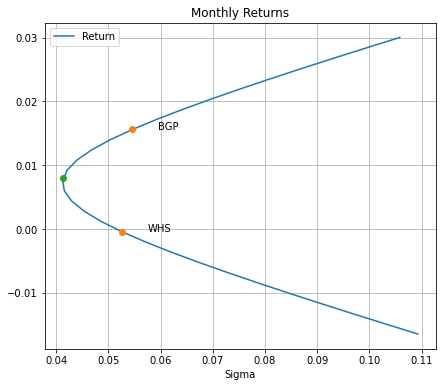

In [47]:
fig, ax = plt.subplots(figsize=(7,6))
ax.set_title(r'Monthly Returns')
dfeff.plot(ax=ax, grid=True)
ax.plot(sigma.to_list(), mean_ret.to_list(), 'o') # assets
ax.plot(GMVP_sigma, GMVP_ret, 'o') # assets
# Labels
ax.text(sigma['BGP']+0.005,mean_ret['BGP'],'BGP')
ax.text(sigma['WHS']+0.005,mean_ret['WHS'],'WHS')
plt.show()

**Applying this to multiple pairs of stocks**

In [48]:
nzx_set, df_close = returns(nzx+['^NZ50'], '2011-10-01', '2022-04-30')

[*********************100%***********************]  153 of 153 completed

10 Failed downloads:
- BIF.NZ: No data found for this date range, symbol may be delisted
- BRMWG.NZ: No data found, symbol may be delisted
- ALD.NZ: Data doesn't exist for startDate = 1317380400, endDate = 1651233600
- NTLOB.NZ: No data found, symbol may be delisted
- KFLWG.NZ: No data found, symbol may be delisted
- JPG.NZ: No data found for this date range, symbol may be delisted
- AKL.NZ: No data found, symbol may be delisted
- CO2.NZ: No data found for this date range, symbol may be delisted
- PLP.NZ: No data found for this date range, symbol may be delisted
- FCT.NZ: No data found for this date range, symbol may be delisted


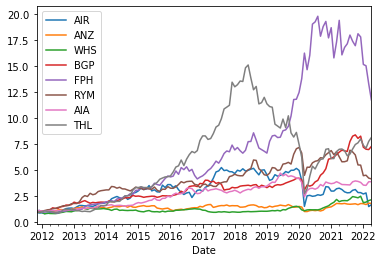

In [49]:
stocks_list = ["AIR", "ANZ", 'WHS', 'BGP', 'FPH', 'RYM', 'AIA', 'THL']  # tickers seperated by space
data = df_close[stocks_list]

# Calculate monthly returns
monthly_ret = np.log(data).diff().dropna()
monthly_ret.cumsum().apply(np.exp).plot()

mean_ret = monthly_ret.mean()
mean_ret.name = 'Mean Monthly Return'

In [50]:
monthly_ret.mean()

AIR    0.003978
ANZ    0.004614
WHS    0.006003
BGP    0.015740
FPH    0.019556
RYM    0.011274
AIA    0.010734
THL    0.016631
dtype: float64

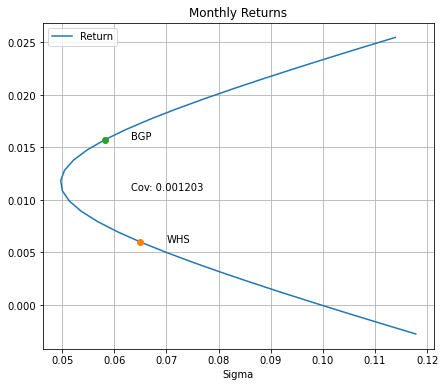

0.0012034063816049705

In [51]:
def demo_two_portfolios(monthly_ret, x, y):
    x_ret = monthly_ret[x].mean()
    y_ret = monthly_ret[y].mean()
    x_sig = monthly_ret[x].std()
    y_sig = monthly_ret[y].std()
    cov_mat  = monthly_ret.cov()
    
    x_var = cov_mat.loc[x][x]
    y_var = cov_mat.loc[y][y]
    
    x_y_cov = cov_mat.loc[y][x]

    x_weight = np.arange(-1,2,0.1)
    y_weight = 1-x_weight

    # Portfolio Z Mean Returns
    xy_ret = x_weight * x_ret + y_weight * y_ret
    #print(pd.Series(xy_ret))
        
    xy_sigma = (x_weight ** 2 * x_var + y_weight ** 2 * y_var + x_weight * y_weight * x_y_cov * 2) ** 0.5
        
    #print(pd.Series(xy_sigma))

    # Envelope
    dfeff = pd.DataFrame({'Sigma': xy_sigma, 'Return': xy_ret}, columns=['Sigma', 'Return'])
    dfeff.set_index('Sigma', inplace=True)
    dfeff.sample(5)

    fig, ax = plt.subplots(figsize=(7,6))
    ax.set_title(r'Monthly Returns')
    dfeff.plot(ax=ax, grid=True)
    ax.plot(x_sig, x_ret, 'o') # assets
    ax.plot(y_sig, y_ret, 'o') # assets
    
    # Labels
    ax.text(x_sig+0.005,x_ret,x)
    ax.text(y_sig+0.005,y_ret,y)
    ax.text(min(x_sig,y_sig)+0.005,(x_ret+y_ret)/2,'Cov: {:2.4}'.format(x_y_cov))
    plt.show()
    return x_y_cov
    
demo_two_portfolios(monthly_ret, 'WHS', 'BGP')

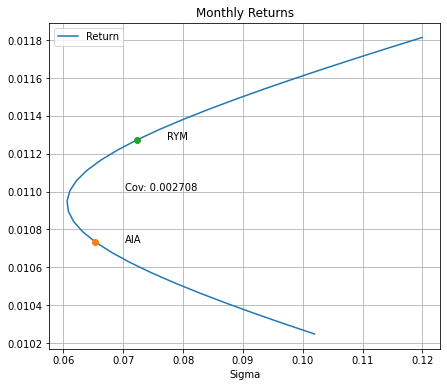

0.0027075437687986903

In [52]:
demo_two_portfolios(monthly_ret, 'AIA', 'RYM')

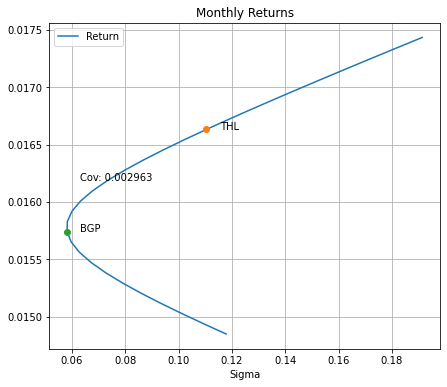

0.0029625188324688702

In [53]:
demo_two_portfolios(monthly_ret, 'THL', 'BGP')